### Brown LHC ML Hackathon

dataset: https://archive.ics.uci.edu/ml/datasets/HIGGS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

path = '/Users/rizki/Documents/Projects/Brown_lhc_ml_hackathon/Higgs_classification/'
data_folder = 'data/'

all_data = path+data_folder+'HIGGS.csv'
signal = path+data_folder+'higgs-signal.csv'
bkg = path+data_folder+'higgs-bgk.csv'

all_df = pd.read_csv(all_data,header=None)

In [5]:

physics_columns=['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

all_df.columns =['label']+physics_columns

sig_df = all_df[all_df['label']==1]
bkg_df = all_df[all_df['label']==0]


In [6]:
print(all_df.shape)
all_df.head()

(11000000, 29)


,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [31]:
## Train test split as instructed by organizer: test set --> last 500k of rows.

train_df = all_df.iloc[:all_df.shape[0]-500000]
test_df = all_df.iloc[all_df.shape[0]-500000:]

print (train_df.shape)
print (test_df.shape)

(10500000, 29)
(500000, 29)


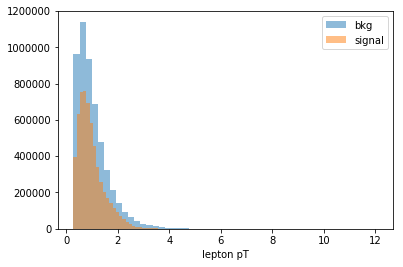

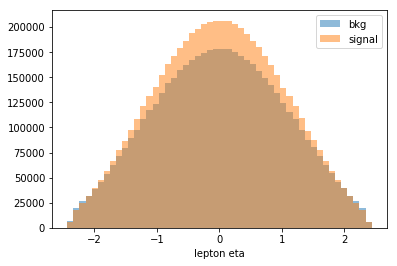

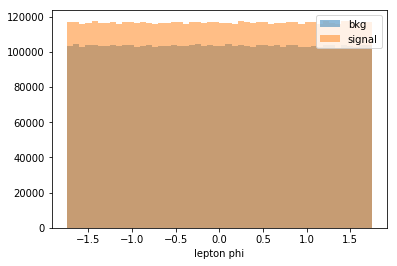

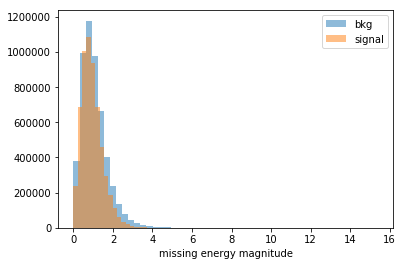

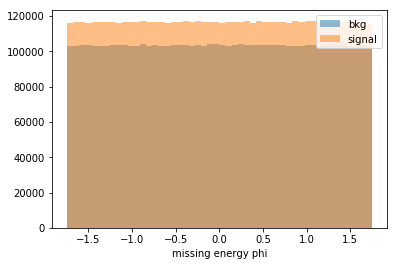

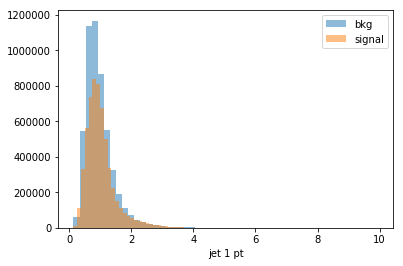

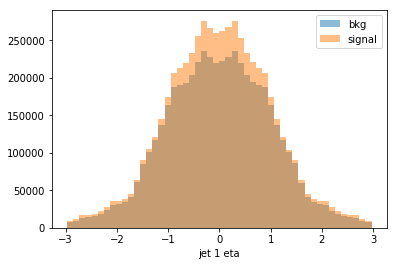

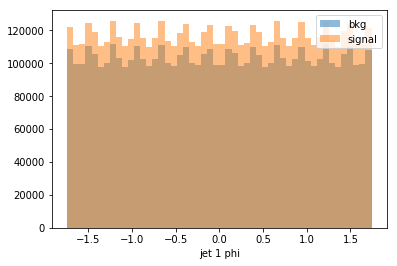

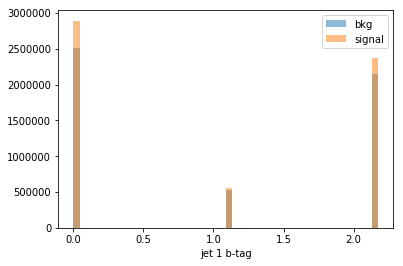

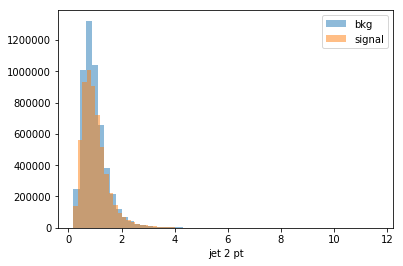

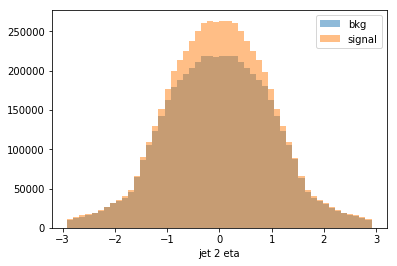

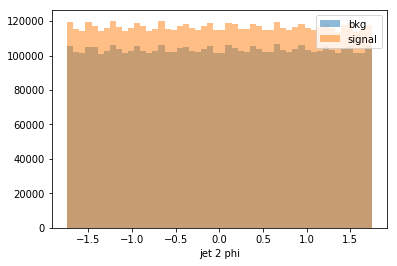

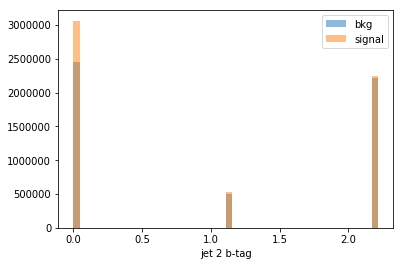

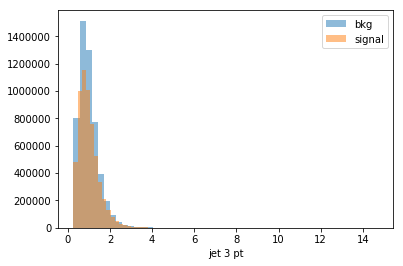

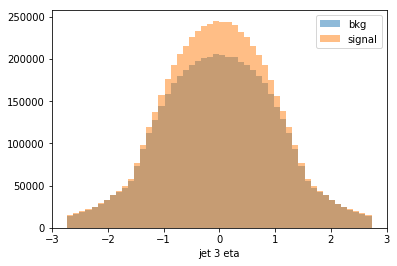

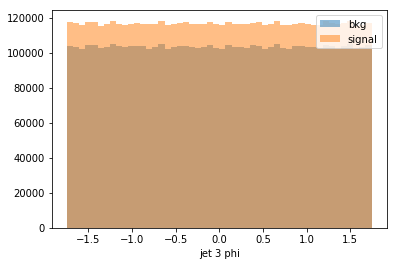

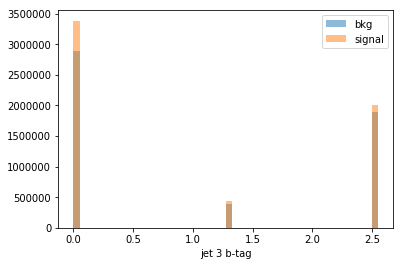

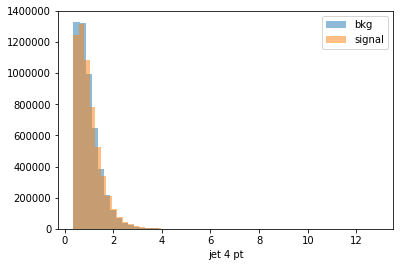

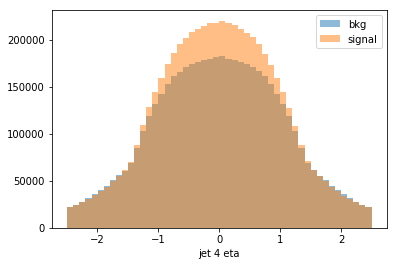

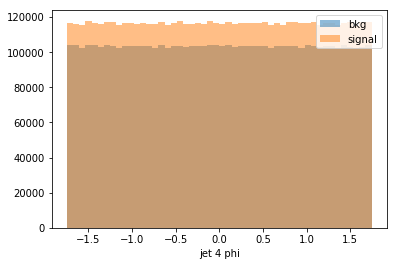

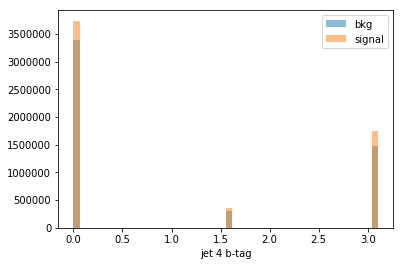

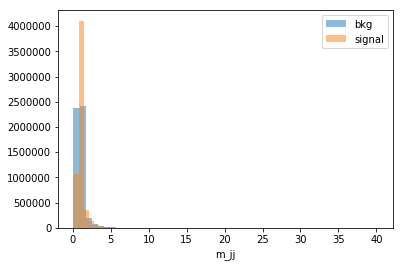

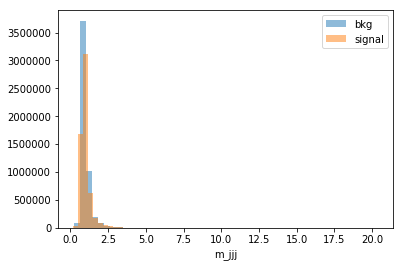

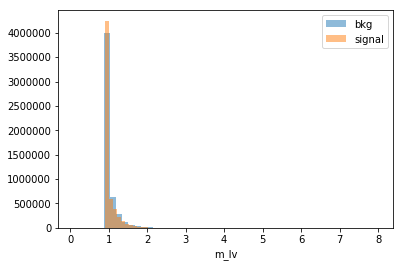

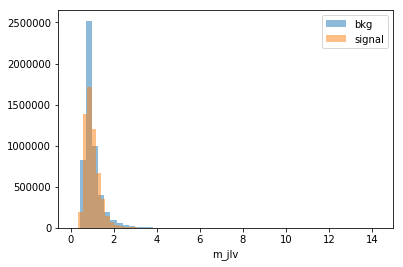

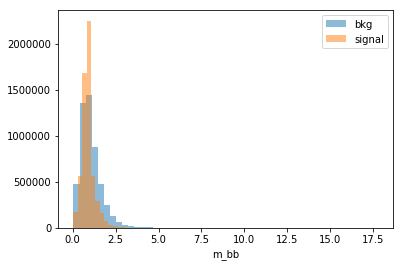

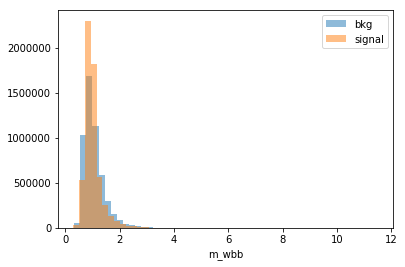

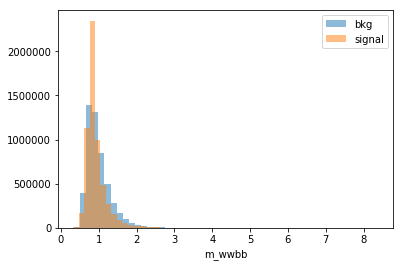

In [8]:
#Plot to have an idea what the features distribution look like

savePath = path+'plots/'
for i,feat in enumerate(physics_columns):
    fig_lepPt = plt.figure(i)
    plt.hist(bkg_df[feat],bins=50,alpha=0.5,label='bkg')
    plt.hist(sig_df[feat],bins=50,alpha=0.5,label='signal')
    plt.xlabel(feat)
    
    plt.legend(loc='upper right')
    #plt.savefig(savePath+feat+'.png')
    plt.show()

In [71]:
# Test validation split -- take only 500k trains samples. Plenty enough.

from sklearn.model_selection import train_test_split, cross_val_score, KFold

X_tr, X_val, y_tr, y_val = train_test_split(train_df[:500000].drop(['label'], axis=1), train_df[:500000]['label'], test_size=0.05, random_state=42)

## Boosted Decision Tree - LightGBM

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.878364	eval's auc: 0.826339
evals_result = 
Plot metrics recorded during training...


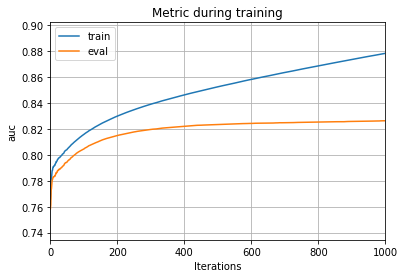

Plot feature importances...


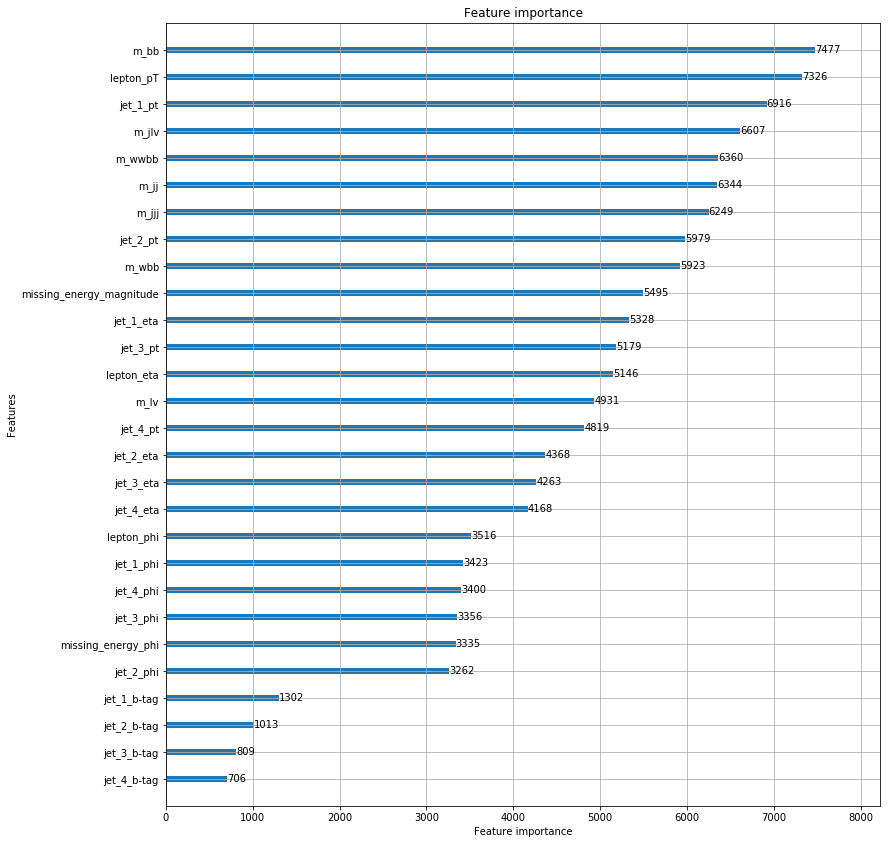

feature importance:
    1 m_bb : 7477
    2 lepton_pT : 7326
    3 jet_1_pt : 6916
    4 m_jlv : 6607
    5 m_wwbb : 6360
    6 m_jj : 6344
    7 m_jjj : 6249
    8 jet_2_pt : 5979
    9 m_wbb : 5923
    10 missing_energy_magnitude : 5495
    11 jet_1_eta : 5328
    12 jet_3_pt : 5179
    13 lepton_eta : 5146
    14 m_lv : 4931
    15 jet_4_pt : 4819
    16 jet_2_eta : 4368
    17 jet_3_eta : 4263
    18 jet_4_eta : 4168
    19 lepton_phi : 3516
    20 jet_1_phi : 3423
    21 jet_4_phi : 3400
    22 jet_3_phi : 3356
    23 missing_energy_phi : 3335
    24 jet_2_phi : 3262
    25 jet_1_b-tag : 1302
    26 jet_2_b-tag : 1013
    27 jet_3_b-tag : 809
    28 jet_4_b-tag : 706


In [82]:
import lightgbm as lgb

evals_result={}

lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_test = lgb.Dataset(X_val, label=y_val)

lgb_params = {
               'feature_fraction': .75,
               'metric': 'auc',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'cross_entropy', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 1000
verbose_eval = num_boost_round/20
lgb_model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=200,
                  verbose_eval=verbose_eval)

print ('evals_result = '),evals_result

print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(lgb_model, max_num_features=X_val.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

print ('feature importance:')
sorted_index = np.argsort(lgb_model.feature_importance())
for i in range(len(lgb_model.feature_name())-1,0-1,-1):
    print (' '*3,(len(lgb_model.feature_name())-i), lgb_model.feature_name()[sorted_index[i]],':',lgb_model.feature_importance()[sorted_index[i]])

In [83]:

from sklearn.metrics import roc_auc_score

pred_lgb_tr = lgb_model.predict(X_tr)
print('Train set AUC using LightGBM is %f' % roc_auc_score(y_tr,pred_lgb_tr))
pred_lgb_val = lgb_model.predict(X_val)
print('Val set AUC using LightGBM is %f' % roc_auc_score(y_val, pred_lgb_val))

#Predict using test set.
pred_lgb_test = lgb_model.predict(test_df.drop(columns=['label']))
print('Test set AUC using LightGBM is %f' % roc_auc_score(test_df['label'], pred_lgb_test))


Train set AUC using LightGBM is 0.878364
Val set AUC using LightGBM is 0.826339
Test set AUC using LightGBM is 0.829609


## Simple DNN - Keras + TF

In [74]:
#Normalize input. --> for some reason the scores become worse. maybe this norm method is not optimal.
# X_tr_norm = pd.DataFrame()
# X_val_norm = pd.DataFrame()
# for feat in physics_columns:
#     X_tr_norm[feat] = X_tr[feat]/X_tr[feat].max()
#     X_val_norm[feat] = X_val[feat]/X_val[feat].max()

# test_df_norm = pd.DataFrame()
# for feat in ['label']+physics_columns:
#     test_df_norm[feat] = test_df[feat]/test_df[feat].max()

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
import tensorflow as tf

# create model
dnn_model = Sequential()
dnn_model.add(Dense(128, input_dim=28, activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(Dense(4, activation='relu'))
dnn_model.add(Dense(2, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

# Compile model
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Fit the model
dnn_model.fit(X_tr, y_tr, 
              epochs=100, 
              batch_size=256,
              shuffle=True,
              validation_split=0.1,
              callbacks=[early_stop]
             )

Train on 427500 samples, validate on 47500 samples
Epoch 1/100
427500/427500 [==============================] - 11s 25us/step - loss: 0.6308 - acc: 0.6467 - val_loss: 0.6071 - val_acc: 0.6754
Epoch 2/100
427500/427500 [==============================] - 9s 22us/step - loss: 0.5886 - acc: 0.6877 - val_loss: 0.5785 - val_acc: 0.6973
Epoch 3/100
427500/427500 [==============================] - 10s 22us/step - loss: 0.5722 - acc: 0.7006 - val_loss: 0.5647 - val_acc: 0.7085
Epoch 4/100
427500/427500 [==============================] - 10s 23us/step - loss: 0.5615 - acc: 0.7091 - val_loss: 0.5601 - val_acc: 0.7097
Epoch 5/100
427500/427500 [==============================] - 10s 23us/step - loss: 0.5536 - acc: 0.7151 - val_loss: 0.5534 - val_acc: 0.7159
Epoch 6/100
427500/427500 [==============================] - 11s 26us/step - loss: 0.5477 - acc: 0.7194 - val_loss: 0.5507 - val_acc: 0.7180
Epoch 7/100
427500/427500 [==============================] - 10s 24us/step - loss: 0.5420 - acc: 0.7240 

In [76]:
# evaluate the model
scores = dnn_model.evaluate(X_tr, y_tr)
print("\n%s: %.2f%%" % (dnn_model.metrics_names[1], scores[1]*100))

475000/475000 [==============================] - 18s 37us/step

acc: 75.56%


In [77]:
dnn_predictions_tr = dnn_model.predict(X_tr)
print('Train set AUC using Simple DNN is %f' % roc_auc_score(y_tr,dnn_predictions_tr))
dnn_predictions_val = dnn_model.predict(X_val)
print('Val set AUC using Simple DNN is %f' % roc_auc_score(y_val, dnn_predictions_val))

Train set AUC using Simple DNN is 0.842221
Val set AUC using Simple DNN is 0.823905


In [78]:
dnn_predictions_test = dnn_model.predict(test_df.drop(columns=['label']))
print('Test set AUC using Simple DNN is %f' % roc_auc_score(test_df['label'], dnn_predictions_test))

Test set AUC using Simple DNN is 0.825590


## Stack BDT and DNN with LinReg Meta layer

In [84]:
pred_lgb_tr_s = pd.Series(pred_lgb_tr)
dnn_predictions_tr_s = pd.Series(dnn_predictions_tr.ravel())
pred_tr_df = pd.DataFrame({'lgb':pred_lgb_tr_s,'dnn':dnn_predictions_tr_s})

pred_lgb_val_s = pd.Series(pred_lgb_val)
dnn_predictions_val_s = pd.Series(dnn_predictions_val.ravel())
pred_val_df = pd.DataFrame({'lgb':pred_lgb_val_s,'dnn':dnn_predictions_val_s})

pred_lgb_test_s = pd.Series(pred_lgb_test)
dnn_predictions_test_s = pd.Series(dnn_predictions_test.ravel())
pred_test_df = pd.DataFrame({'lgb':pred_lgb_test_s,'dnn':dnn_predictions_test_s})

In [85]:
from sklearn.linear_model import LogisticRegression, LinearRegression

linr_model = LinearRegression()

In [86]:
linr_model.fit(pred_tr_df, y_tr)
pred_linr_tr = linr_model.predict(pred_tr_df)
print('Train set AUC using Meta LinReg is %f' % roc_auc_score(y_tr,pred_linr_tr))

Train set AUC using Meta LinReg is 0.878445


In [87]:
linr_model.fit(pred_val_df, y_val)
pred_linr_val = linr_model.predict(pred_val_df)
print('Val set AUC using Meta LinReg is %f' % roc_auc_score(y_val,pred_linr_val))

Val set AUC using Meta LinReg is 0.834640


In [88]:
linr_model.fit(pred_test_df, test_df['label'])
pred_linr_test = linr_model.predict(pred_test_df)
print('Test set AUC using Meta LinReg is %f' % roc_auc_score(test_df['label'],pred_linr_test))

Test set AUC using Meta LinReg is 0.837211
